# Projenin amacı en yüksek hacimli 50 şirketin 2019 yılındaki açılış fiyatını tahmin eden model oluşturmak


# Keşifsel Veri Analizi

         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
<class 'pandas.core.frame.DataFrame'>
Index: 62858 entries, 0 to 610226
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    62858 non-null  object 
 1   open    62858 non-null  float64
 2   high    62858 non-null  float64
 3   low     62858 non-null  float64
 4   close   62858 non-null  float64
 5   volume  62858 non-null  int64  
 6   Name    62858 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 3.8+ MB
None
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64
               open          high           low         c

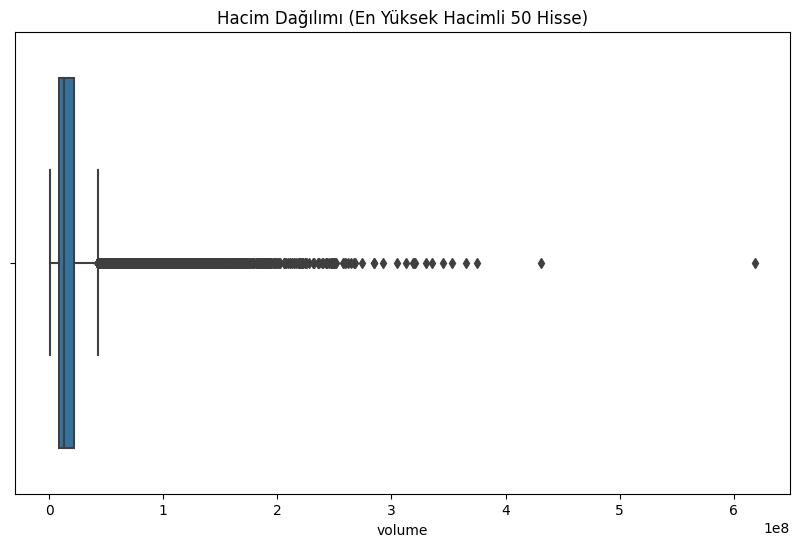

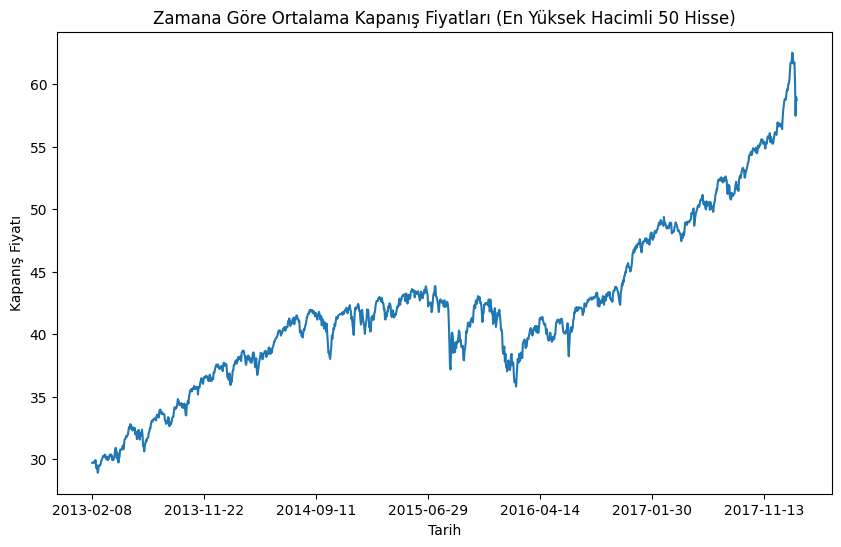

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yüklüyoruz
data = pd.read_csv('/kaggle/input/sandp500/all_stocks_5yr.csv')

# Hacmi en yüksek 50 hisseyi buluyoruz
top_50_volume_stocks = data.groupby('Name')['volume'].sum().nlargest(50).index
filtered_data = data[data['Name'].isin(top_50_volume_stocks)]
print(filtered_data.head())
print(filtered_data.info())
print(filtered_data.isnull().sum())
print(filtered_data.describe())

plt.figure(figsize=(10,6))
sns.boxplot(data=filtered_data, x='volume')
plt.title('Hacim Dağılımı (En Yüksek Hacimli 50 Hisse)')
plt.show()
# Zaman serisine göre kapanış fiyatlarını görselleştiriyoruz
plt.figure(figsize=(10,6))
filtered_data.groupby('date')['close'].mean().plot()
plt.title('Zamana Göre Ortalama Kapanış Fiyatları (En Yüksek Hacimli 50 Hisse)')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.show()


# Eksik Verileri Temizleme

In [33]:
filtered_data.loc[:, 'date'] = pd.to_datetime(filtered_data['date'])
# Eksik verileri ortalama ile dolduruyoruz
filtered_data.loc[:, 'open'] = filtered_data['open'].fillna(filtered_data['open'].mean())
filtered_data.loc[:, 'close'] = filtered_data['close'].fillna(filtered_data['close'].mean())
filtered_data.loc[:, 'high'] = filtered_data['high'].fillna(filtered_data['high'].mean())
filtered_data.loc[:, 'low'] = filtered_data['low'].fillna(filtered_data['low'].mean())
filtered_data.loc[:, 'volume'] = filtered_data['volume'].fillna(filtered_data['volume'].mean())

print(filtered_data.isnull().sum())


date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


# Veri Hazırlığı ve Model Eğitimi


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

filtered_data['date'] = pd.to_datetime(filtered_data['date'])


X = filtered_data[['high', 'low', 'close', 'volume']]
y = filtered_data['open']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Modeli oluşturma ve eğitme
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


/tmp/ipykernel_36/359374689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = pd.to_datetime(filtered_data['date'])


Mean Absolute Error: 0.1962383191218579


# Adım 4: Gelecekteki Tarih İçin Tahmin

In [35]:

future_high_value = filtered_data['high'].mean()
future_low_value = filtered_data['low'].mean()
future_close_value = filtered_data['close'].mean()
future_volume_value = filtered_data['volume'].mean()

future_data = pd.DataFrame({
    'high': [future_high_value], 
    'low': [future_low_value], 
    'close': [future_close_value], 
    'volume': [future_volume_value]
})


future_data_scaled = scaler.transform(future_data)
# 2019 yılı için açılış fiyatını tahmin ediyoruz
future_open_price = model.predict(future_data_scaled)
print(f"2019 için Tahmin Edilen Açılış Fiyatı: {future_open_price[0]}")


2019 için Tahmin Edilen Açılış Fiyatı: 42.008156


# Adım 5: Hisselerin İsmine Göre Açılış Fiyatlarını Görselleştirme

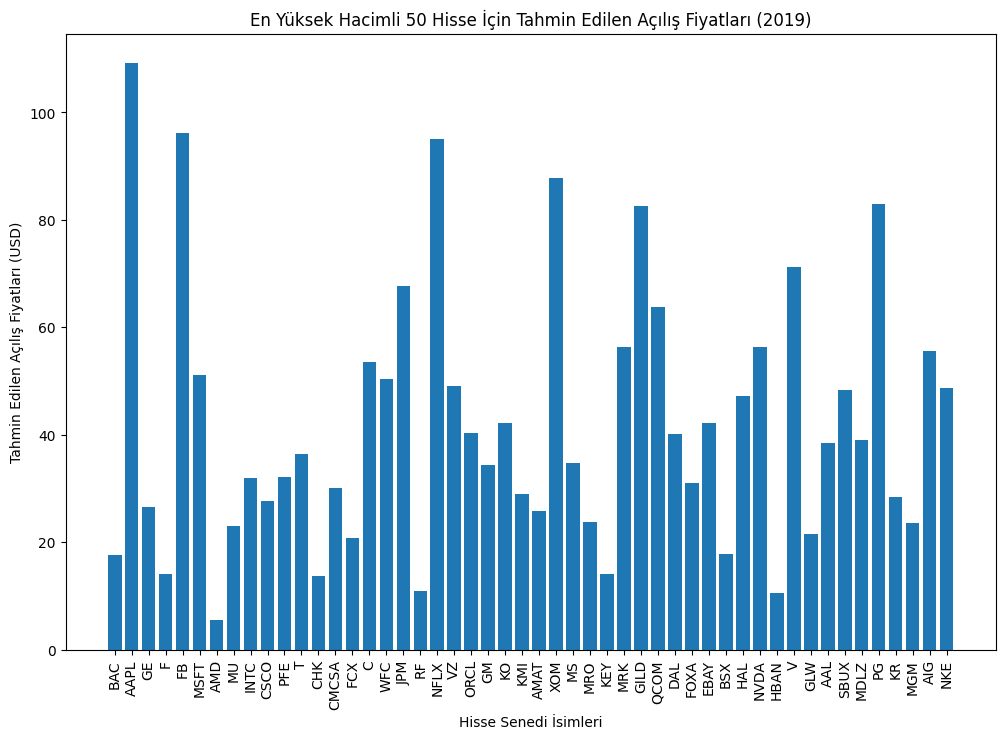

In [36]:
predicted_open_prices = []

for name in top_50_volume_stocks:
    stock_data = filtered_data[filtered_data['Name'] == name]
    future_high_value = stock_data['high'].mean()
    future_low_value = stock_data['low'].mean()
    future_close_value = stock_data['close'].mean()
    future_volume_value = stock_data['volume'].mean()

    future_data = pd.DataFrame({
        'high': [future_high_value], 
        'low': [future_low_value], 
        'close': [future_close_value], 
        'volume': [future_volume_value]
    })

    future_data_scaled = scaler.transform(future_data)
    predicted_price = model.predict(future_data_scaled)
    predicted_open_prices.append(predicted_price[0])

plt.figure(figsize=(12,8))
plt.bar(top_50_volume_stocks, predicted_open_prices)
plt.xlabel('Hisse Senedi İsimleri')
plt.ylabel('Tahmin Edilen Açılış Fiyatları (USD)')
plt.title('En Yüksek Hacimli 50 Hisse İçin Tahmin Edilen Açılış Fiyatları (2019)')
plt.xticks(rotation=90)
plt.show()
